# Option Pricer – Black–Scholes and Implied Volatility Analysis

## 1. Introduction

The objective of this project is to implement a generic option pricing framework in Python and apply it to listed equity options using real market data.

More specifically, the project focuses on:
- the implementation of the Black–Scholes model for pricing European call and put options,
- the computation of implied volatility from observed market prices,
- the analysis of implied volatility skews and term structures,
- the comparison between theoretical prices and observed market prices.

All computations are performed using Python.

---

## 2. Choice of the underlying asset

The underlying asset chosen for this study is **Oracle Corporation (ORCL)**.

Oracle is a large-cap US technology company with:
- a liquid equity market,
- an actively traded options market,
- multiple available maturities and a wide range of strikes.

These characteristics make ORCL a suitable underlying for studying implied volatility patterns while remaining close to real market conditions.

Although ORCL is used as a case study, all pricing and implied volatility functions implemented in this project are designed to be **generic** and can be applied to any equity option with similar characteristics.

---

## 3. Market conventions and assumptions

In order to build a consistent and generic pricing framework, several market conventions and simplifying assumptions are adopted throughout the project.

### 3.1 Underlying price

The spot price \( S \) of the underlying asset is taken as the last available market price of ORCL at the time of data retrieval.

The spot price is assumed to remain constant during the pricing of the option chain.

---

### 3.2 Time to maturity

For each option, the time to maturity \( T \) is computed as the fraction of years between the current date and the option’s expiration date.

A simple **ACT/365** day-count convention is used:

$$
T = \frac{\text{Expiration date} - \text{Current date}}{365}
$$


---

### 3.3 Risk-free interest rate

The risk-free interest rate \( r \) is assumed to be constant and identical for all maturities.

For simplicity, a flat annualized risk-free rate is used throughout the project.

This assumption is consistent with the Black–Scholes framework and allows us to focus on implied volatility dynamics rather than interest rate modeling.

---

### 3.4 Dividend yield

The dividend yield \( q \) of the underlying asset is assumed to be constant.

When dividend information is available, a continuous dividend yield is used. Otherwise, the dividend yield is set to zero.

This approach ensures that the pricing functions remain generic and applicable to a wide range of equities.

---

### 3.5 Option market prices

The observed market price of an option is defined as:
- the mid-price \( (Bid + Ask) / 2 \) whenever bid and ask quotes are available,
- otherwise, the last traded price.

Options with inconsistent or illiquid quotes are filtered out during the data cleaning stage.

---

## 4. Scope and limitations

This project focuses exclusively on **European options** and relies on the assumptions of the Black–Scholes model.

In particular:
- volatility is assumed to be constant over the life of the option,
- markets are assumed to be frictionless,
- transaction costs, taxes, and liquidity effects are ignored in the pricing model.

Any discrepancy between theoretical prices and observed market prices should therefore be interpreted in light of these assumptions, as well as potential data quality issues.


## 5. The Black–Scholes model

### 5.1 Model overview

The Black–Scholes model provides a closed-form solution for pricing European call and put options under a set of simplifying assumptions.

Under the risk-neutral measure, the price of the underlying asset is assumed to follow a geometric Brownian motion with constant volatility and drift equal to the risk-free rate adjusted for dividends.

The model allows us to express the option price as a function of observable market parameters and a single unobservable parameter: the volatility.

---

### 5.2 Model assumptions

The Black–Scholes framework relies on the following assumptions:

- the underlying asset price follows a lognormal diffusion process,
- the volatility of the underlying asset is constant,
- the risk-free interest rate is constant,
- dividends are paid continuously at a constant rate,
- markets are frictionless (no transaction costs or arbitrage opportunities),
- trading is continuous,
- options are European-style and can only be exercised at maturity.

While these assumptions are restrictive, the Black–Scholes model remains a benchmark in option pricing and provides a useful reference for implied volatility analysis.

---

### 5.3 Black–Scholes pricing formulas

Let:
- $S$ be the spot price of the underlying asset,
- $K$ the strike price,
- $T$ the time to maturity (in years),
- $r$ the continuously compounded risk-free rate,
- $q$ the continuous dividend yield,
- $\sigma$ the volatility of the underlying asset.

Define:
$$
d_1 = \frac{\ln\left(\frac{S}{K}\right) + \left(r - q + \frac{1}{2}\sigma^2\right)T}{\sigma \sqrt{T}},
\quad
d_2 = d_1 - \sigma \sqrt{T}
$$


The Black–Scholes price of a European **call option** is given by:
$$
C = S e^{-qT} N(d_1) - K e^{-rT} N(d_2)
$$


The price of a European **put option** is given by:
$$
P = K e^{-rT} N(-d_2) - S e^{-qT} N(-d_1)
$$


where $N(\cdot)$ denotes the cumulative distribution function of the standard normal distribution.


---

### 5.4 Interpretation

The Black–Scholes formulas express option prices as discounted expected payoffs under the risk-neutral measure.

The term $S e^{-qT}$ represents the forward-adjusted value of the underlying asset, while $K e^{-rT}$ corresponds to the discounted strike price.

The parameters $d_1$ and $d_2$ capture the standardized distance between the spot price and the strike, adjusted for time, volatility, and carry.


---

### 5.5 Objective of the implementation

The goal of the next section is to implement a **generic Black–Scholes pricing function** in Python that:
- handles both call and put options,
- supports dividend-paying stocks,
- can be reused for pricing and implied volatility computations,
- remains independent of the underlying asset.

This function will serve as the core building block of the option pricer.


In [1]:
import sys
import os

sys.path.append(os.path.abspath("src"))

from pricer.black_scholes import black_scholes_price
from pricer.implied_vol import implied_vol


In [2]:
#Test

S, K, T, r, q, sigma = 100, 100, 1.0, 0.03, 0.0, 0.25
price = black_scholes_price("call", S, K, T, r, q, sigma)
iv = implied_vol("call", price, S, K, T, r, q)

print(price, iv)


11.348476825143514 0.24999999999505104


## 7. Option data retrieval – Yahoo Finance

In order to compare theoretical prices and implied volatilities with market data,
option prices are retrieved from Yahoo Finance.

Yahoo Finance provides option chain data through the `yfinance` Python library.
For a given underlying asset, the option chain contains listed call and put options
across multiple maturities and strikes, along with several market variables such as
bid, ask, volume, open interest and implied volatility.

In this section, we retrieve the option chain for Oracle Corporation (ORCL) and
explore the structure of the resulting datasets.


In [3]:
import yfinance as yf
import pandas as pd
from datetime import datetime

In [4]:
ticker = yf.Ticker("ORCL")

In [5]:
spot = ticker.history(period="1d")["Close"].iloc[-1]
spot

np.float64(197.58990478515625)

In [6]:
expirations = ticker.options
expirations

('2025-12-26',
 '2026-01-02',
 '2026-01-09',
 '2026-01-16',
 '2026-01-23',
 '2026-01-30',
 '2026-02-20',
 '2026-03-20',
 '2026-04-17',
 '2026-05-15',
 '2026-06-18',
 '2026-07-17',
 '2026-08-21',
 '2026-09-18',
 '2026-12-18',
 '2027-01-15',
 '2027-06-17',
 '2027-09-17',
 '2027-12-17',
 '2028-01-21')

In [7]:
expiration = expirations[0]
expiration

'2025-12-26'

In [8]:
option_chain = ticker.option_chain(expiration)

calls = option_chain.calls
puts = option_chain.puts

In [9]:
calls.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,ORCL251226C00115000,2025-12-24 14:55:28+00:00,115.0,81.47,80.30,83.55,1.139999,1.419145,6,4,3.582032,True,REGULAR,USD
1,ORCL251226C00120000,2025-12-24 14:55:28+00:00,120.0,76.47,75.30,78.55,1.130005,1.499874,6,4,3.339845,True,REGULAR,USD
2,ORCL251226C00125000,2025-12-23 19:32:28+00:00,125.0,69.46,70.30,73.55,0.000000,0.000000,2,7,3.105471,True,REGULAR,USD
3,ORCL251226C00130000,2025-12-19 19:46:39+00:00,130.0,63.44,65.35,68.55,0.000000,0.000000,124,0,2.880862,True,REGULAR,USD
4,ORCL251226C00135000,2025-12-24 15:16:12+00:00,135.0,62.15,60.35,63.55,2.050003,3.410987,1,57,2.663089,True,REGULAR,USD


In [10]:
puts.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,ORCL251226P00115000,2025-12-23 17:13:45+00:00,115.0,0.01,0.0,0.01,0.0,0.0,3.0,0,1.875001,False,REGULAR,USD
1,ORCL251226P00120000,2025-12-23 17:13:45+00:00,120.0,0.06,0.0,0.01,0.0,0.0,2.0,60,1.750001,False,REGULAR,USD
2,ORCL251226P00125000,2025-12-22 14:36:39+00:00,125.0,0.01,0.0,0.01,0.0,0.0,1.0,0,1.625002,False,REGULAR,USD
3,ORCL251226P00130000,2025-12-22 16:15:05+00:00,130.0,0.01,0.0,0.01,0.0,0.0,32.0,0,1.468753,False,REGULAR,USD
4,ORCL251226P00135000,2025-12-22 15:05:03+00:00,135.0,0.02,0.0,0.04,0.0,0.0,15.0,0,1.531252,False,REGULAR,USD


The option chain dataframes contain several important columns:

- `strike`: option strike price
- `lastPrice`: last traded price
- `bid` / `ask`: bid and ask quotes
- `volume`: trading volume
- `openInterest`: open interest
- `impliedVolatility`: implied volatility provided by Yahoo Finance
- `inTheMoney`: indicator of moneyness

These variables will be used to filter liquid options and to compare market implied
volatility with the values computed using the Black–Scholes model.

## 8. Data cleaning and liquidity filtering

Raw option chain data often contain illiquid or inconsistent quotes that are not
suitable for quantitative analysis.

In order to obtain reliable implied volatility estimates, we restrict the analysis
to relatively liquid options and apply several filtering criteria based on market
microstructure considerations.

The goal of this cleaning step is to retain options that:
- are actively traded,
- have meaningful bid–ask quotes,
- are not too far in- or out-of-the-money.

In [11]:
import numpy as np
from datetime import datetime

In [12]:
# Current date
today = datetime.today()

# Expiration date
expiry_date = datetime.strptime(expiration, "%Y-%m-%d")

# Time to maturity in years (ACT/365)
T = (expiry_date - today).days / 365
T

0.0027397260273972603

In [13]:
def market_option_price(row):
    if row["bid"] > 0 and row["ask"] > 0:
        return 0.5 * (row["bid"] + row["ask"])
    else:
        return row["lastPrice"]

In [14]:
calls = calls.copy()
puts = puts.copy()

calls["market_price"] = calls.apply(market_option_price, axis=1)
puts["market_price"] = puts.apply(market_option_price, axis=1)

In [15]:
# Parameters for filtering
MIN_VOLUME = 10
MAX_MONEYNESS_DEVIATION = 0.2  # |S/K - 1| <= 20%

# Moneyness
calls["moneyness"] = spot / calls["strike"]
puts["moneyness"] = spot / puts["strike"]

# Liquidity filters
calls_clean = calls[
    (calls["volume"] >= MIN_VOLUME) &
    (calls["bid"] > 0) &
    (calls["ask"] > 0) &
    (np.abs(calls["moneyness"] - 1) <= MAX_MONEYNESS_DEVIATION)
]

puts_clean = puts[
    (puts["volume"] >= MIN_VOLUME) &
    (puts["bid"] > 0) &
    (puts["ask"] > 0) &
    (np.abs(puts["moneyness"] - 1) <= MAX_MONEYNESS_DEVIATION)
]


The following liquidity criteria are applied:

- **Positive trading volume**: options with zero volume are likely stale or inactive.
- **Valid bid–ask quotes**: ensures a meaningful market price can be defined.
- **Moneyness filter**: options that are very far in- or out-of-the-money are often
  illiquid and exhibit unstable implied volatilities.

These filters significantly improve the quality and stability of the implied
volatility analysis.

In [16]:
print(f"Calls before cleaning: {len(calls)}")
print(f"Calls after cleaning:  {len(calls_clean)}")

print(f"Puts before cleaning:  {len(puts)}")
print(f"Puts after cleaning:   {len(puts_clean)}")

Calls before cleaning: 69
Calls after cleaning:  21
Puts before cleaning:  60
Puts after cleaning:   19


## 9. Implied volatility skew for equity options

For equity options, implied volatility typically exhibits a **negative skew**:
implied volatility is higher for low strikes (out-of-the-money puts) and lower for
high strikes (out-of-the-money calls).

This asymmetric structure reflects the downside risk inherent to equity markets,
the demand for downside protection, and the leverage effect linking price declines
to volatility increases.

The implied volatility skew is defined as the relationship between implied volatility
and the strike price for a fixed maturity. However, in practice, this relationship
must be analyzed carefully, as implied volatility estimates for very deep in- or
out-of-the-money options are often noisy due to low liquidity.

In this section, we analyze the implied volatility skew for ORCL equity options by
focusing on a relevant range of strikes around the at-the-money level, where market
prices are the most informative.


In [17]:
ATM_BAND = 0.15  # +/- 15% around ATM

calls_skew = calls_clean[np.abs(calls_clean["moneyness"] - 1) <= ATM_BAND].copy()

puts_skew = puts_clean[np.abs(puts_clean["moneyness"] - 1) <= ATM_BAND].copy()


In [18]:
MAX_IV = 1.5  # Remove clearly noisy implied volatilities

calls_skew = calls_skew[calls_skew["impliedVolatility"] <= MAX_IV]
puts_skew  = puts_skew[puts_skew["impliedVolatility"] <= MAX_IV]

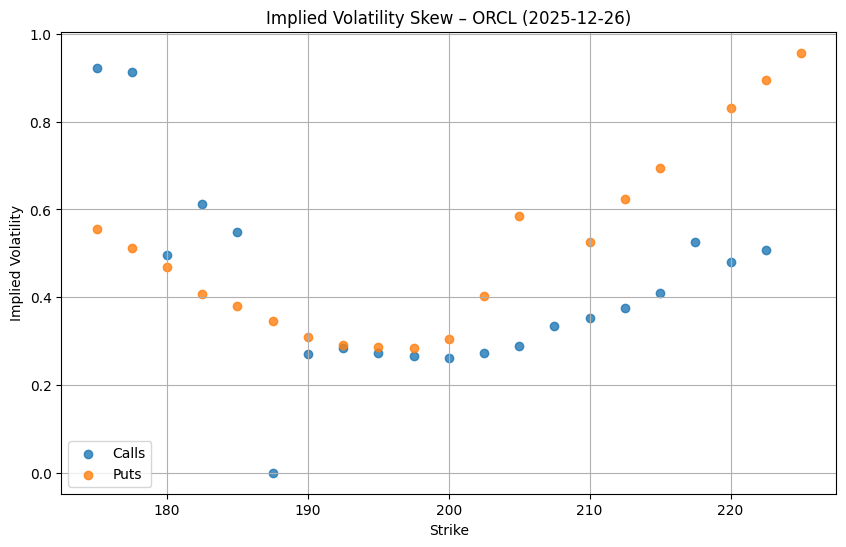

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.scatter(calls_skew["strike"],calls_skew["impliedVolatility"],label="Calls",alpha=0.8)

plt.scatter(puts_skew["strike"],puts_skew["impliedVolatility"],label="Puts",alpha=0.8)


plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.title(f"Implied Volatility Skew – ORCL ({expiration})")
plt.legend()
plt.grid(True)

plt.show()


The implied volatility curve exhibits a clear negative equity skew.

Implied volatility reaches its minimum close to the at-the-money region, where
liquidity is highest. Volatility increases more sharply for lower strikes, especially
for out-of-the-money puts, reflecting strong demand for downside protection.

Although implied volatility also increases for higher strikes, the slope is much
flatter on the call side, highlighting the asymmetric nature of equity risk.

High implied volatility levels observed for far out-of-the-money options should be
interpreted with caution, as they may be influenced by low liquidity and market
microstructure effects rather than pure volatility expectations.


## 10. Term structure of implied volatility

Beyond the cross-sectional analysis of implied volatility across strikes (skew),
it is also informative to analyze how implied volatility evolves across maturities.

The **term structure of implied volatility** describes the relationship between
implied volatility and time to maturity for a fixed strike or level of moneyness.

This analysis provides insights into market expectations of future uncertainty and
the relative importance of short-term versus long-term risks.


In [20]:
expirations = ticker.options
len(expirations)

20

In [21]:
TARGET_MONEYNESS = 1.0      # ATM
TOL_MONEYNESS = 0.03        # +/- 3% around ATM
MAX_IV = 1.5                # safety cap

In [22]:
term_structure = []

today = datetime.today()

for exp in expirations:
    expiry_date = datetime.strptime(exp, "%Y-%m-%d")
    T = (expiry_date - today).days / 365
    
    if T <= 0:
        continue

    chain = ticker.option_chain(exp)
    calls = chain.calls.copy()
    puts  = chain.puts.copy()

    # Add moneyness
    calls["moneyness"] = spot / calls["strike"]
    puts["moneyness"]  = spot / puts["strike"]

    # Focus on near-ATM options
    calls_atm = calls[
        (np.abs(calls["moneyness"] - TARGET_MONEYNESS) <= TOL_MONEYNESS) &
        (calls["volume"] > 0) &
        (calls["impliedVolatility"] <= MAX_IV)]

    if len(calls_atm) == 0:
        continue

    # Average IV across near-ATM calls
    iv_atm = calls_atm["impliedVolatility"].mean()

    term_structure.append({"T": T,"impliedVolatility": iv_atm})

term_df = pd.DataFrame(term_structure).sort_values("T")
term_df


,T,impliedVolatility
0,0.002740,0.271296
1,0.021918,0.354230
2,0.041096,0.398016
3,0.060274,0.413702
4,0.079452,0.413336
5,0.098630,0.435430
6,0.156164,0.443090
7,0.232877,0.510549
8,0.309589,0.501424
9,0.386301,0.505559


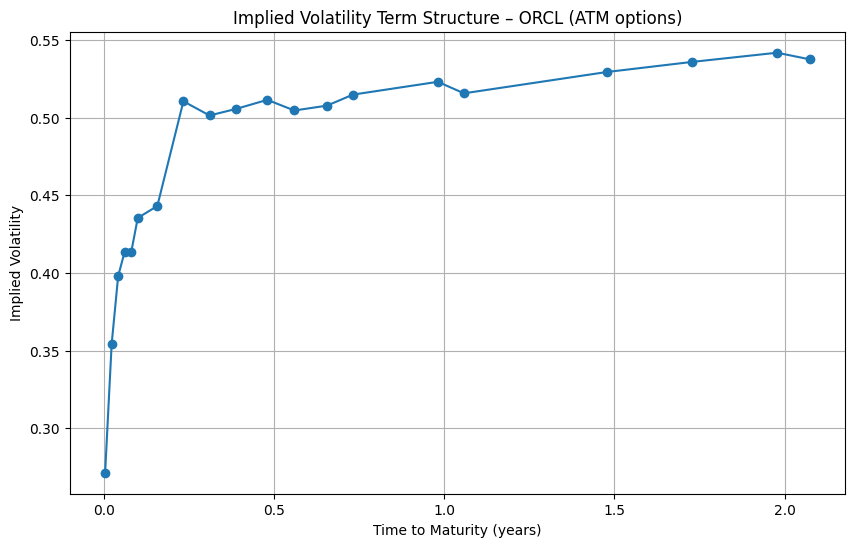

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(term_df["T"],term_df["impliedVolatility"],marker="o")

plt.xlabel("Time to Maturity (years)")
plt.ylabel("Implied Volatility")
plt.title("Implied Volatility Term Structure – ORCL (ATM options)")
plt.grid(True)

plt.show()


The implied volatility term structure exhibits a clear upward-sloping shape.

Very short-dated implied volatility is relatively low, while volatility increases
rapidly for short to medium maturities. This pattern reflects the presence of
near-term uncertainty, such as earnings announcements or firm-specific events, which
are priced into options with maturities beyond the very short term.

For longer maturities, implied volatility stabilizes and evolves more smoothly,
indicating that long-term uncertainty is perceived as more persistent and less
event-driven.

Overall, the observed term structure suggests that short-term risk is driven by
discrete events, while long-term implied volatility reflects structural uncertainty
about the firm’s future prospects.

## 11. Implied volatility surface ("Nappe de Vol")

Implied volatility depends jointly on the strike price and the time to maturity.
The combination of the volatility skew and the term structure forms the **implied
volatility surface**, also referred to as a volatility nappe.

Visualizing this surface provides a comprehensive view of how market-implied risk
varies across both dimensions and highlights departures from the constant volatility
assumption of the Black–Scholes model.


In [24]:
surface_frames = []

today = datetime.today()

for exp in expirations:
    expiry_date = datetime.strptime(exp, "%Y-%m-%d")
    T = (expiry_date - today).days / 365

    if T <= 0:
        continue

    calls = ticker.option_chain(exp).calls.copy()

    calls["moneyness"] = spot / calls["strike"]
    calls["T"] = T

    calls = calls[(np.abs(calls["moneyness"] - 1) <= ATM_BAND) &
        (calls["volume"] > 0) &
        (calls["impliedVolatility"] <= MAX_IV)
    ][["strike", "T", "impliedVolatility"]]

    surface_frames.append(calls)

surface_df = pd.concat(surface_frames, ignore_index=True)
surface_df.head()


,strike,T,impliedVolatility
0,172.5,0.00274,0.920899
1,175.0,0.00274,0.913087
2,177.5,0.00274,0.904298
3,180.0,0.00274,0.460943
4,182.5,0.00274,0.602543


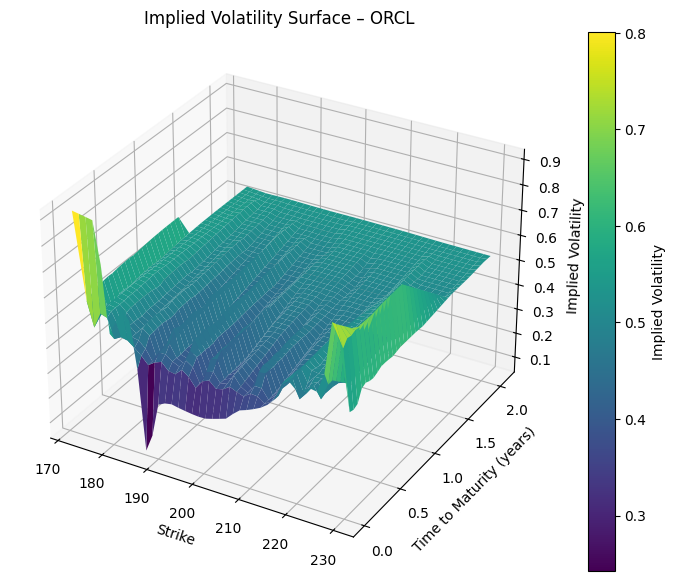

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Extract data
K  = surface_df["strike"].to_numpy()
T  = surface_df["T"].to_numpy()
IV = surface_df["impliedVolatility"].to_numpy()

# Grid
K_grid = np.linspace(K.min(), K.max(), 40)
T_grid = np.linspace(T.min(), T.max(), 40)
K_mesh, T_mesh = np.meshgrid(K_grid, T_grid)

# Interpolation
IV_mesh = griddata((K, T), IV, (K_mesh, T_mesh), method="linear")

# Plot surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(projection="3d")

surf = ax.plot_surface(
    K_mesh, T_mesh, IV_mesh,
    cmap="viridis", edgecolor="none"
)

ax.set(
    xlabel="Strike",
    ylabel="Time to Maturity (years)",
    zlabel="Implied Volatility",
    title="Implied Volatility Surface – ORCL"
)

fig.colorbar(surf, ax=ax, label="Implied Volatility")
plt.show()


The implied volatility surface summarizes the joint dependence of implied volatility
on strike and maturity. 
It exhibits a negative equity skew across maturities and an
upward-sloping term structure, highlighting the limitations of the constant volatility
assumption in the Black–Scholes model.

## 12. Comparison between market and model-implied volatilty

In this section, we compare the volatility implied by the Black–Scholes model
with those observed in the market.

In [26]:
expiry_date = datetime.strptime(expiration, "%Y-%m-%d")
T_scalar = (expiry_date - datetime.today()).days / 365

comparison = calls_clean.copy()
comparison["T"] = T_scalar
comparison["r"] = r
comparison["q"] = q

comparison[["T", "r", "q"]].head()


,T,r,q
13,0.00274,0.03,0.0
15,0.00274,0.03,0.0
16,0.00274,0.03,0.0
17,0.00274,0.03,0.0
18,0.00274,0.03,0.0


In [27]:
comparison["iv_model"] = comparison.apply(
    lambda row: implied_vol(
        option_type="call",
        market_price=row["market_price"],
        S=spot,
        K=row["strike"],
        T=row["T"],
        r=row["r"],
        q=row["q"]
    ),
    axis=1
)

In [28]:
comparison["iv_diff"] = comparison["iv_model"] - comparison["impliedVolatility"]

comparison = comparison.dropna(subset=["iv_model", "impliedVolatility"])

comparison[["strike", "impliedVolatility", "iv_model", "iv_diff"]]


,strike,impliedVolatility,iv_model,iv_diff
22,192.5,0.284675,0.364040,0.079365
23,195.0,0.272712,0.447759,0.175047
24,197.5,0.265144,0.451284,0.186140
25,200.0,0.260505,0.445886,0.185380
26,202.5,0.273445,0.462355,0.188910
27,205.0,0.288581,0.492502,0.203921
28,207.5,0.334968,0.552621,0.217653
29,210.0,0.351569,0.593425,0.241856
30,212.5,0.375006,0.636013,0.261007
31,215.0,0.410162,0.691688,0.281526


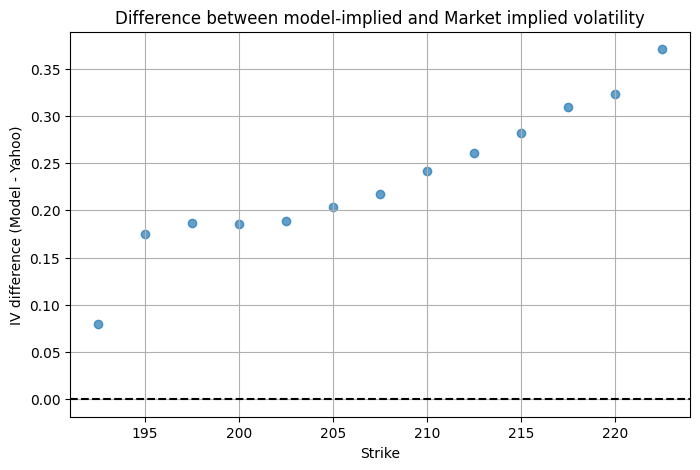

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(
    comparison["strike"],
    comparison["iv_diff"],
    alpha=0.7
)
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Strike")
plt.ylabel("IV difference (Model - Yahoo)")
plt.title("Difference between model-implied and Market implied volatility")
plt.grid(True)
plt.show()


The table and figure above compare market-implied volatility with
model-implied volatility computed using the Black–Scholes framework.

Model-implied volatility is systematically higher than market-implied volatility for
this maturity, with the difference increasing as the strike moves away from the
at-the-money level. This pattern reflects the inability of a constant-volatility
model to fully capture the observed volatility skew.


## 13. Comparison between market and theoretical option prices

In this section, we compare the option prices implied by the Black–Scholes model with
those observed in the market.

In [30]:
comparison["price_bs"] = comparison.apply(lambda row: black_scholes_price(option_type="call",S=spot,K=row["strike"],T=row["T"],r=row["r"],q=row["q"],sigma=row["iv_model"]),axis=1)

In [31]:
comparison["price_diff"] = (comparison["price_bs"] - comparison["market_price"])

comparison[["strike", "market_price", "price_bs", "price_diff"]]

,strike,market_price,price_bs,price_diff
22,192.5,5.250,5.250,5.343281e-12
23,195.0,3.425,3.425,4.679368e-11
24,197.5,1.915,1.915,5.478906e-11
25,200.0,0.895,0.895,2.831069e-12
26,202.5,0.395,0.395,1.294552e-08
27,205.0,0.180,0.180,9.049023e-08
28,207.5,0.110,0.110,-2.609467e-08
29,210.0,0.060,0.060,-3.151740e-09
30,212.5,0.035,0.035,3.507550e-08
31,215.0,0.025,0.025,9.204093e-08


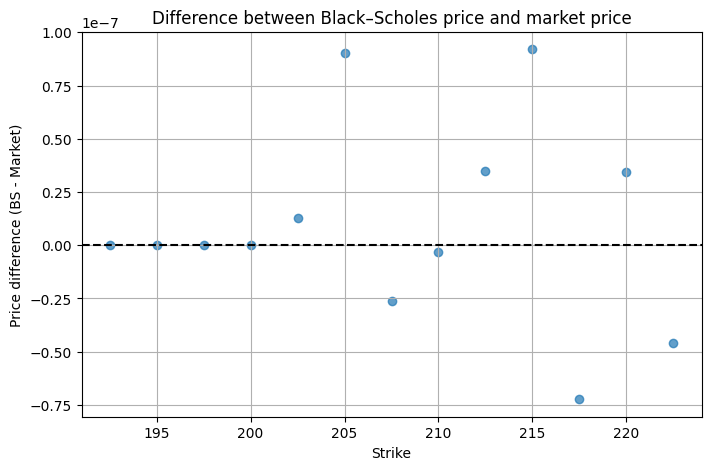

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(comparison["strike"],comparison["price_diff"],alpha=0.7)

plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Strike")
plt.ylabel("Price difference (BS - Market)")
plt.title("Difference between Black–Scholes price and market price")
plt.grid(True)
plt.show()


The figure above shows the difference between Black–Scholes theoretical prices and
observed market prices. Pricing errors are small and centered around zero, indicating
that the Black–Scholes model provides a reasonable approximation of market prices when
using model-implied volatility.

## Final conclusion

This project implemented a complete option pricing workflow, combining the
Black–Scholes model with real market data. The analysis highlights the presence of
volatility skew and term structure effects, illustrating the limitations of the
constant-volatility assumption.

Overall, implied volatility emerges as the central market variable driving option
prices, while the Black–Scholes model provides a reasonable approximation when used
with market-consistent inputs.